# Week 9
# Develop a Residual Network for image classification.


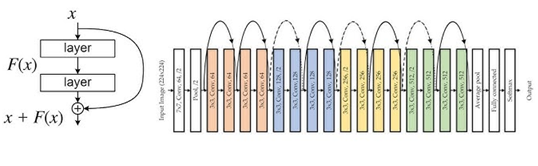

In [4]:
# simple_resnet_cifar10_gpu.py
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import os

def enable_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Detected {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}")
        try:
            # Enable memory growth for each GPU (prevents TF from grabbing all GPU memory)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"Logical GPUs: {len(logical_gpus)}")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(f"Could not set memory growth: {e}")
    else:
        print("No GPU detected. Running on CPU.")

def residual_block(x, filters, stride=1):
    shortcut = x
    in_ch = tf.keras.backend.int_shape(x)[-1]

    # conv -> BN -> ReLU
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # conv -> BN
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # projection if channels or spatial dims change
    if stride != 1 or in_ch != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_simple_resnet(input_shape=(32,32,3), num_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 2 blocks per stage (like small ResNet)
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inp, outputs=out, name='SimpleResNet')

def load_data():
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test  = x_test.astype('float32') / 255.0
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    return (x_train, y_train), (x_test, y_test)

def train_and_eval(epochs=20, batch_size=128, lr=1e-3):
    # Try to enable GPU and configure distribution strategy
    enable_gpu()
    gpus = tf.config.list_physical_devices('GPU')

    if gpus and len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print("Using MirroredStrategy for multi-GPU training.")
    else:
        # Single GPU or CPU
        strategy = tf.distribute.get_strategy()
        if gpus:
            print("Using single GPU.")
        else:
            print("Using CPU.")

    (x_train, y_train), (x_test, y_test) = load_data()

    # If GPU present you may want to increase batch size for better utilization
    if gpus:
        recommended_bs = batch_size * max(1, len(gpus))
        print(f"Original batch_size={batch_size}. If you want to utilize GPUs fully consider batch_size={recommended_bs} (optional).")

    with strategy.scope():
        model = build_simple_resnet()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

    model.summary()
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2)
    loss, acc = model.evaluate(x_test, y_test, verbose=1)
    print(f"Test accuracy: {acc:.4f}  Test loss: {loss:.4f}")
    return model, (x_test, y_test)

def show_predictions(model, x_test, y_test, n=8):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    idxs = np.random.choice(len(x_test), n, replace=False)
    preds = model.predict(x_test[idxs])
    pred_labels = np.argmax(preds, axis=1)
    plt.figure(figsize=(12,3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i+1)
        plt.imshow(x_test[idx])
        plt.title(f"P:{class_names[pred_labels[i]]}\nT:{class_names[y_test[idx]]}")
        plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # You can change epochs/batch_size here
    model, (x_test, y_test) = train_and_eval(epochs=12, batch_size=128)
    show_predictions(model, x_test, y_test, n=8)


No GPU detected. Running on CPU.
Using CPU.


Model: "SimpleResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │      1,728 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_26[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_27[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 32, 32,    │          0 │ add_12[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_28[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_29[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 2,782,154 (10.61 MB)

 Trainable params: 2,777,674 (10.60 MB)

 Non-trainable params: 4,480 (17.50 KB)

Epoch 1/12


KeyboardInterrupt: 